In [12]:
# Importing necessary libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Constructing an ImageDataGenerator object
DIRECTORY = 'Covid19-dataset/train'
CLASS_MODE = 'categorical'
COLOR_MODE = 'grayscale'
TARGET_SIZE = (256, 256)
BATCH_SIZE = 32

training_data_generator = ImageDataGenerator(rescale=1./255,
    rotation_range=25,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
)

validation_data_generator = ImageDataGenerator()

training_iterator = training_data_generator.flow_from_directory(DIRECTORY, class_mode='categorical', color_mode='grayscale', batch_size=BATCH_SIZE)

batch_data = next(training_iterator)

print("\nLoading validation data...")

validation_iterator = validation_data_generator.flow_from_directory(DIRECTORY,class_mode='categorical', color_mode='grayscale',batch_size=BATCH_SIZE)



Found 251 images belonging to 3 classes.



Loading validation data...
Found 251 images belonging to 3 classes.


In [4]:
# Printing its attributes:
print(training_data_generator.__dict__)

print("\nBuilding the model...")

# Building the model:
def build_model(training_data):
    model = Sequential()
    model.add(tf.keras.Input(shape=(256, 256, 1)))
    model.add(layers.Conv2D(5, 5, strides=2, activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(layers.Dropout(0.1))
    model.add(layers.Conv2D(3, 3, strides=1, activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(layers.Dropout(0.2))
    model.add(tf.keras.layers.Conv2D(3, 3, strides=1, activation="relu"))
    model.add(tf.keras.layers.Conv2D(1, 1, strides=1, activation="relu"))
    model.add(tf.keras.layers.Dropout(0.1))
    model.add(layers.Flatten())
    model.add(layers.Dense(3, activation='softmax'))
    print("\nCompiling the model...")
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.001), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=[tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.AUC()],)
    model.summary()
    return model

{'featurewise_center': False, 'samplewise_center': False, 'featurewise_std_normalization': False, 'samplewise_std_normalization': False, 'zca_whitening': False, 'zca_epsilon': 1e-06, 'rotation_range': 25, 'width_shift_range': 0.05, 'height_shift_range': 0.05, 'shear_range': 0.0, 'zoom_range': [0.9, 1.1], 'channel_shift_range': 0.0, 'fill_mode': 'nearest', 'cval': 0.0, 'horizontal_flip': False, 'vertical_flip': False, 'rescale': 0.00392156862745098, 'preprocessing_function': None, 'dtype': 'float32', 'interpolation_order': 1, 'data_format': 'channels_last', 'channel_axis': 3, 'row_axis': 1, 'col_axis': 2, '_validation_split': 0.0, 'mean': None, 'std': None, 'zca_whitening_matrix': None, 'brightness_range': None}

Building the model...


In [5]:
model = build_model(training_iterator)


Compiling the model...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 5)    │           130 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 5)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 63, 63, 5)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 3)      │           138 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 30, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 3)      │            84 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 1)      │             4 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │         2,355 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,711 (10.59 KB)

 Trainable params: 2,711 (10.59 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
es = EarlyStopping(monitor='val_auc', mode='min', verbose=1, patience=10)

In [7]:
print("\nTraining the model...")

# Training the model
history = model.fit(training_iterator, steps_per_epoch=int(training_iterator.samples/BATCH_SIZE), epochs=50, validation_data=validation_iterator, validation_steps=int(validation_iterator.samples/BATCH_SIZE), callbacks=[es])


Training the model...


e:\Codecademy\Mini_DL_projects\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 399ms/step - auc: 0.5416 - categorical_accuracy: 0.3394 - loss: 1.0977 - val_auc: 0.6032 - val_categorical_accuracy: 0.3973 - val_loss: 1.7190
Epoch 2/50
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - auc: 0.5530 - categorical_accuracy: 0.3125 - loss: 1.0975

e:\Codecademy\Mini_DL_projects\venv\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - auc: 0.5530 - categorical_accuracy: 0.3125 - loss: 1.0975 - val_auc: 0.6014 - val_categorical_accuracy: 0.3884 - val_loss: 1.9171
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 317ms/step - auc: 0.6066 - categorical_accuracy: 0.5468 - loss: 1.0948 - val_auc: 0.6044 - val_categorical_accuracy: 0.4018 - val_loss: 2.4517
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - auc: 0.5344 - categorical_accuracy: 0.4375 - loss: 1.0958 - val_auc: 0.6307 - val_categorical_accuracy: 0.4107 - val_loss: 2.4143
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 325ms/step - auc: 0.7471 - categorical_accuracy: 0.6368 - loss: 1.0902 - val_auc: 0.6459 - val_categorical_accuracy: 0.4643 - val_loss: 3.8492
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - auc: 0.7195 - categorical_accuracy: 0.6250 - loss: 1.0823 - val_auc: 0.6263 - val_categorical_accuracy: 0.4464 - val_loss: 4.2973
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 322ms/step - auc: 0.7658 - categorical_accuracy: 0.6072 - loss

In [9]:
print(history.history.keys())

dict_keys(['auc', 'categorical_accuracy', 'loss', 'val_auc', 'val_categorical_accuracy', 'val_loss'])


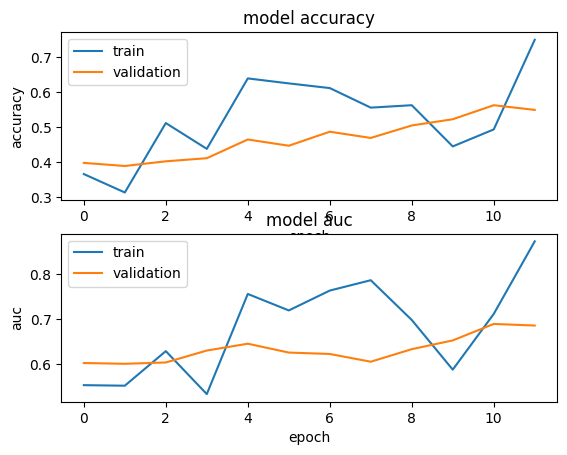

In [10]:
# plotting categorical and validation accuracy over epochs
fig = plt.figure()
ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(history.history['categorical_accuracy'])
ax1.plot(history.history['val_categorical_accuracy'])
ax1.set_title('model accuracy')
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')
ax1.legend(['train', 'validation'], loc='upper left')

# plotting auc and validation auc over epochs
ax2 = fig.add_subplot(2, 1, 2)
ax2.plot(history.history['auc'])
ax2.plot(history.history['val_auc'])
ax2.set_title('model auc')
ax2.set_xlabel('epoch')
ax2.set_ylabel('auc')
ax2.legend(['train', 'validation'], loc='upper left')

plt.show()

In [13]:
# Calculate the number of steps for prediction
test_steps_per_epoch = int(np.ceil(validation_iterator.samples / validation_iterator.batch_size))

# Predict on the validation set
predictions = model.predict(validation_iterator, steps=test_steps_per_epoch)

# Get predicted class indices
predicted_classes = np.argmax(predictions, axis=1)

# Get true class indices
true_classes = validation_iterator.classes

# Get class labels
class_labels = list(validation_iterator.class_indices.keys())

# Print classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step
              precision    recall  f1-score   support

       Covid       0.59      0.09      0.16       111
      Normal       0.29      0.57      0.38        70
   Pneumonia       0.26      0.34      0.29        70

    accuracy                           0.29       251
   macro avg       0.38      0.33      0.28       251
weighted avg       0.41      0.29      0.26       251



In [14]:
cm=confusion_matrix(true_classes,predicted_classes)
print(cm)

[[10 58 43]
 [ 3 40 27]
 [ 4 42 24]]
